## 프로젝트 : Segmentation map으로 도로 이미지 만들기¶

### 데이터 로드하기

In [15]:
import os

data_path=os.getcwd()+'/cityscapes/train/'
print("number of train examples:",len(os.listdir(data_path)))

number of train examples: 1000


1000개의 이미지 확인

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

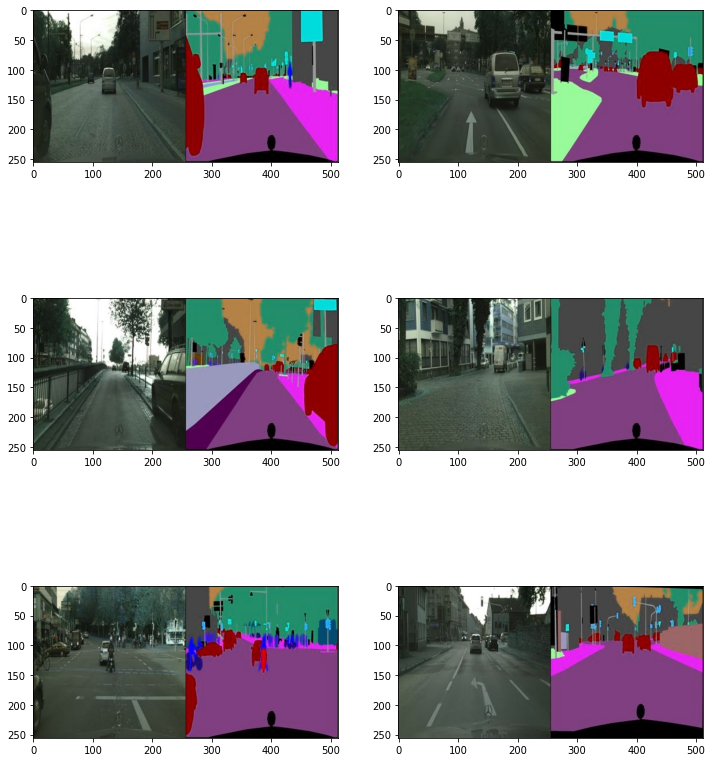

In [17]:
plt.figure(figsize=(12,15))
for i in range(1,7):
    f=data_path+os.listdir(data_path)[np.random.randint(1000)]
    img=cv2.imread(f,cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

#### 크기 확인

In [18]:
f=data_path+os.listdir(data_path)[0]
img=cv2.imread(f,cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용

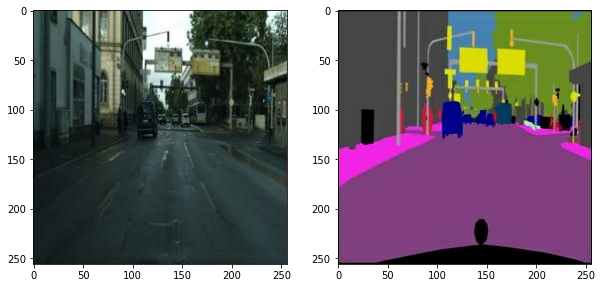

In [19]:
import tensorflow as tf

def normalize(x):
    x=tf.cast(x,tf.float32) #텐서를 새로운 형태로 변형
    return (x/127.5)-1

def denormalize(x):
    x=(x+1)*127.5
    x=x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img=tf.io.read_file(img_path) #전체 내용이 포함된 텐서를 반환
    img=tf.image.decode_image(img,3) #디코딩하고 픽셀 데이터를 포함하는 텐서를 재구성
    
    w=tf.shape(img)[1]//2
    original=img[:,:w,:]
    original=tf.cast(original,tf.float32)
    seg_map=img[:,w:,:]
    seg_map=tf.cast(seg_map,tf.float32)
    return normalize(original),normalize(seg_map)

f=data_path+os.listdir(data_path)[1]
original,seg_map=load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1);plt.imshow(denormalize(original))
plt.subplot(1,2,2);plt.imshow(denormalize(seg_map))
    

#### 한 가지 이상의 augmentation 방법을 적용하여 학습
- 사진 크롭과 좌우 반전 시행 
- 도로여서 위아래 반전 할 경우 도로가 하늘로 가서 위아래 반전은 하지 않음

In [20]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function()
def apply_augmentation(original,seg_map):
    stacked=tf.concat([original,seg_map],axis=-1) #채널축으로 연결, 3개축일 경우 6개축으로
    
    _pad=tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(())<.5: #50퍼의 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용
        padded=tf.pad(stacked,_pad,"REFLECT")
    else:
        padded=tf.pad(stacked,_pad,"CONSTANT",constant_values=1.)
        
    out=image.random_crop(padded,size=[256,256,6]) # (256,256,6) 크기를 가진 이미지를 임의로 잘라
    out=image.random_flip_left_right(out)
    
    return out[...,:3],out[...,3:]

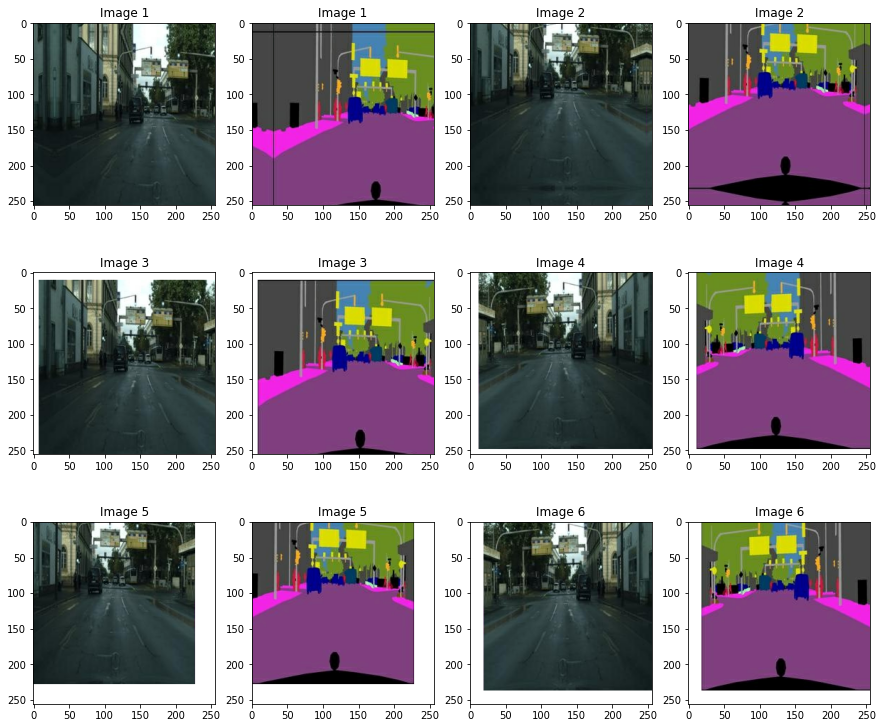

In [21]:
plt.figure(figsize=(15,13))
img_n=1
for i in range(1,13,2):
    augmentated_origin,augmentated_map=apply_augmentation(original,seg_map)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmentated_origin)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmentated_map)); plt.title(f"Image {img_n}")
    img_n += 1    

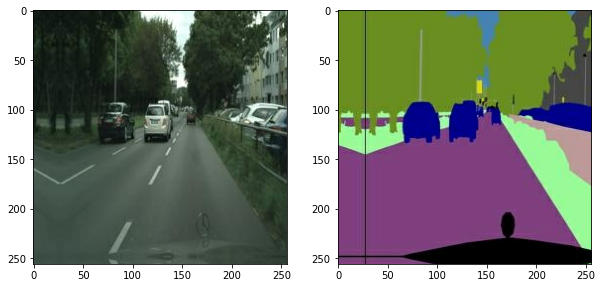

In [22]:
from tensorflow import data

def get_train(img_path):
    original,seg_map=load_img(img_path)
    original,seg_map=apply_augmentation(original,seg_map)
    return original,seg_map

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
original, seg_map = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(original[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(seg_map[0].astype(np.uint8))

## U-Net Generator

Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록

In [1]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)


각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정해 두었으며, blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과

In [2]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [3]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

Decoder를 구현

In [4]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [5]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator 구성

In [6]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


- U-Net Generator
 skip connection 구현

In [7]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

### Discriminator

In [8]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [9]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_30 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [10]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()


In [11]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate[0][0]          

손실함수

In [12]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


optimizer 설정

In [13]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [24]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


#### 학습

In [25]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8184                     
L1_loss:0.3337                     
Discriminator_loss:1.2604

EPOCH[1] - STEP[20]                     
Generator_loss:1.0078                     
L1_loss:0.2886                     
Discriminator_loss:1.0154

EPOCH[1] - STEP[30]                     
Generator_loss:1.1838                     
L1_loss:0.2319                     
Discriminator_loss:0.9399

EPOCH[1] - STEP[40]                     
Generator_loss:1.5752                     
L1_loss:0.2747                     
Discriminator_loss:0.5830

EPOCH[1] - STEP[50]                     
Generator_loss:1.6442                     
L1_loss:0.2692                     
Discriminator_loss:0.6007

EPOCH[1] - STEP[60]                     
Generator_loss:1.9697                     
L1_loss:0.2984                     
Discriminator_loss:1.0314

EPOCH[1] - STEP[70]                     
Generator_loss:1.5122                     
L1_loss:0.1944                    

### 테스트

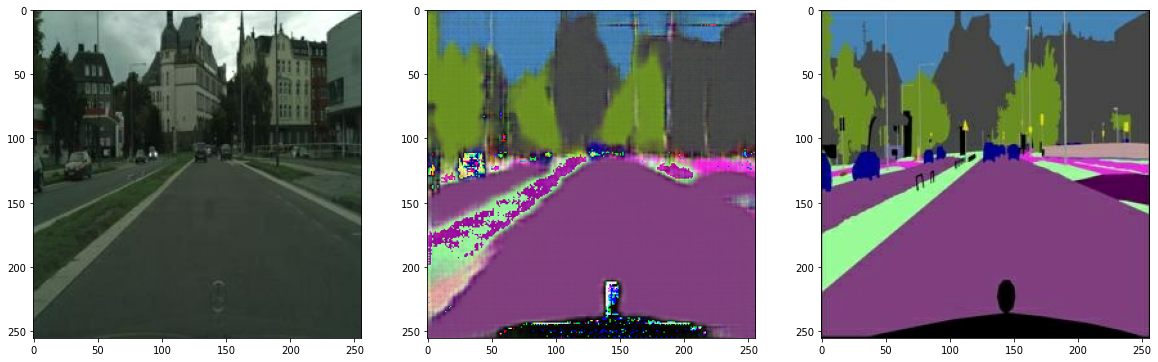

In [26]:
test_ind = 1
test_path=os.getcwd()+'/cityscapes/val/'

f = data_path + os.listdir(test_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

왼쪾이 원본, 가운데가 pix2pix를 통한 map, 오른쪽이 실제 segmentation

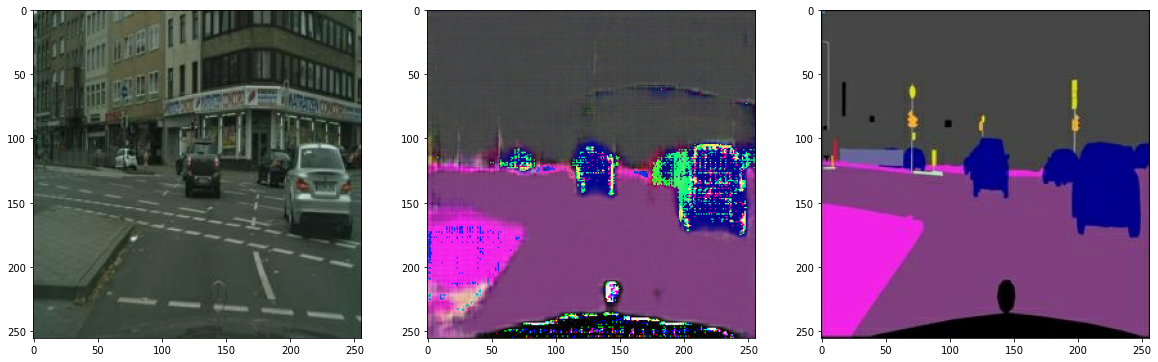

In [27]:
test_ind = 2
test_path=os.getcwd()+'/cityscapes/val/'

f = data_path + os.listdir(test_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

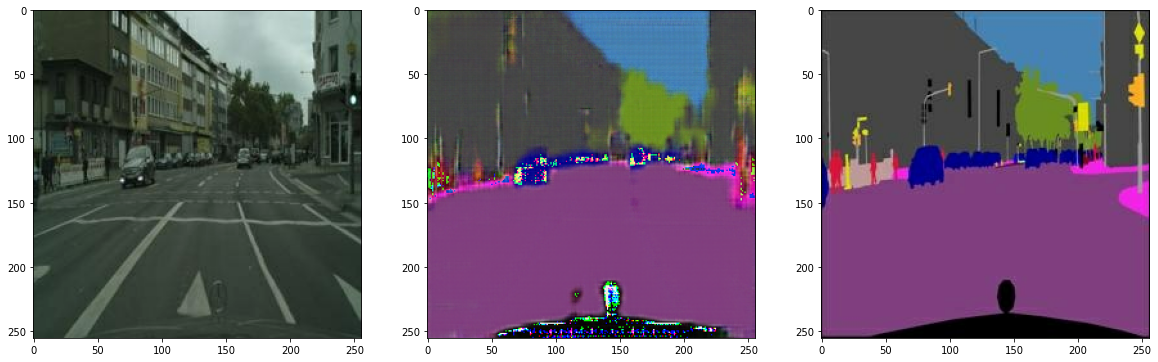

In [28]:
test_ind = 3
test_path=os.getcwd()+'/cityscapes/val/'

f = data_path + os.listdir(test_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

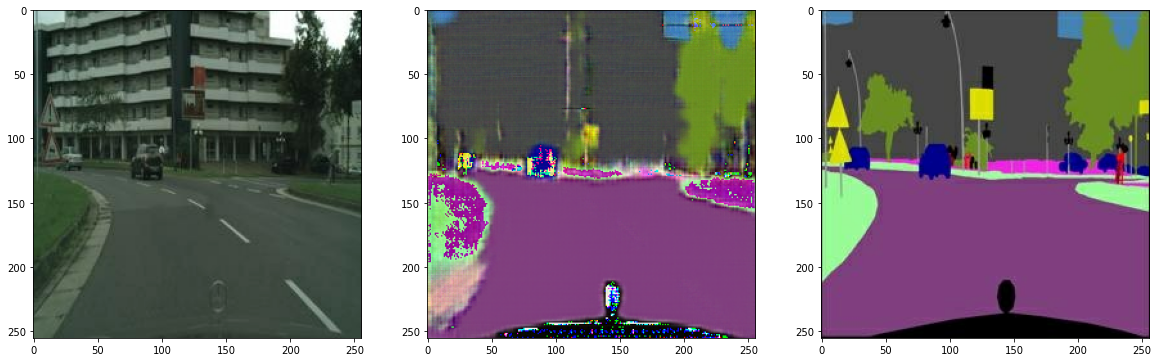

In [29]:
test_ind = 4
test_path=os.getcwd()+'/cityscapes/val/'

f = data_path + os.listdir(test_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

## 회고

반복 20회를 돌려도 아직 경계와 형체를 깔끔히 분리해내지 못한다.
더 돌려보면 경계를 분명히 하는지 보고싶은데.. 너무 오래걸릴까봐 엄두가 안나네요 ^^;; 변명인가..